In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

In [3]:
ref_literature = datasets.reference_publications(taxon)

In [4]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [5]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 141 ms
Wall time: 144 ms


# BioGRID

In [29]:
biogrid_df = biogrid.biogrid('all')

In [30]:
biogrid_df['publication_source'].value_counts()

PUBMED:27708008    326623
PUBMED:20093466     68044
PUBMED:28514442     56431
PUBMED:32296183     52408
PUBMED:22681890     40846
                    ...  
PUBMED:25429067         1
PUBMED:21912673         1
PUBMED:19330023         1
PUBMED:23298890         1
PUBMED:1527169          1
Name: publication_source, Length: 62154, dtype: int64

In [31]:
biogrid_df = biogrid_df[(biogrid_df['throughput'] == 'High Throughput') & 
        (biogrid_df['experimental_system'] == 'Affinity Capture-MS')]
print(biogrid_df['publication_source'].value_counts())
biogrid_df = biogrid_df[biogrid_df['gene_ncbi_interactor_b'].isin(gene_info['gene_ncbi'])]
print(biogrid_df['publication_source'].value_counts())#['publication_source'].value_counts()

PUBMED:28514442    56431
PUBMED:26496610    29089
PUBMED:26186194    23669
PUBMED:22036573    10917
PUBMED:16429126     7592
                   ...  
PUBMED:25139236        1
PUBMED:23913922        1
PUBMED:26718004        1
PUBMED:16222229        1
PUBMED:24277934        1
Name: publication_source, Length: 1235, dtype: int64
PUBMED:28514442    55822
PUBMED:26496610    28952
PUBMED:26186194    23379
PUBMED:27173435     4885
PUBMED:21145461     4487
                   ...  
PUBMED:31159502        1
PUBMED:20388777        1
PUBMED:24067369        1
PUBMED:29228602        1
PUBMED:19786094        1
Name: publication_source, Length: 683, dtype: int64


In [32]:
biogrid_df['pubmed_id'] = biogrid_df['publication_source'].apply(lambda x: int(x.split(':')[1]))

In [33]:
biogrid_df = biogrid_df[biogrid_df['pubmed_id'].isin(gene2pubmed['pubmed_id'])]

In [34]:
biogrid_df['pubmed_id'].value_counts()

27684187    3484
28515276    2785
31091453    2761
29845934    2217
29128334    1964
            ... 
30760284       1
26975375       1
29434030       1
30675521       1
29426904       1
Name: pubmed_id, Length: 461, dtype: int64

In [35]:
biogrid_df = biogrid_df.drop_duplicates(['pubmed_id', 'gene_ncbi_interactor_b']).copy()

In [36]:
biogrid_df['gene_ncbi'] = biogrid_df['gene_ncbi_interactor_b'].copy()

In [37]:
biogrid_df[['pubmed_id']].drop_duplicates().to_csv('../data/aff_ms_pubmed_ids.csv', index=False)

In [14]:
%%time
icite = nih.icite(dataset='citations')

CPU times: total: 20.9 s
Wall time: 23.4 s


In [49]:
def get_genes(gwas):
    # apply filters and p-value threshold here
    gwas = gwas[(gwas['pubmed_id'].isin(gene2pubmed['pubmed_id']))].copy()
    
    print(str(len(set(gwas['pubmed_id'].values))) + ' Aff MS articles')

    de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )

    np.random.seed(49)
    n_samp = 100
    de_sets = []
    de_mentioned_sets = []
    de_mentioned_sets_null = []
    de_citations_mentioned_sets = []
    citations_mentioned_sets = []
    for comparison_key in np.unique(gwas['pubmed_id'].values):
        de_list = de_dict.get(comparison_key)

        if de_dict_mentioned_genes.get(comparison_key):
            de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key)
        else:
            de_list_mentioned_genes = set()

        for n_n in range(n_samp):
            de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                               replace=False, 
                                                               size=len(de_list_mentioned_genes & de_list))))

        de_sets.append(de_list)
        de_mentioned_sets.append(de_list_mentioned_genes)
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)

    icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()

    icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')

    icite_slice = pd.merge(gwas[['gene_ncbi', 'pubmed_id']].drop_duplicates(), 
                     icite_slice, 
                     left_on='pubmed_id', right_on='referenced')

    icite_slice = icite_slice[icite_slice['gene_ncbi_x'] == icite_slice['gene_ncbi_y']]

    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    pad = 0.2

    prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

    de_list = set(gwas['gene_ncbi']) & prot_genes #.union(*de_sets) & prot_genes
    de_list_mentioned_genes = de_list & set(gene2pubmed[gene2pubmed['pubmed_id'].isin(gwas['pubmed_id'])]['gene_ncbi']) & prot_genes
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null) & prot_genes
    de_citations_mentioned_sets = de_list & set(icite_slice['gene_ncbi_y'])
    #itations_mentioned_sets = set().union(*citations_mentioned_sets) & prot_genes
    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')

    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes_null]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes]).fillna(0.0) + 1)[0].values, 
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_citations_mentioned_sets]).fillna(0.0) + 1)[0].values]

    ax.boxplot(data, widths=2*pad-(pad/4), positions=np.arange(len(data))+1, whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2), 
               whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

    ax.set_xlim([1-2.5*pad, 5+2.5*pad])
    ax.set_yscale('log')
    ax.set_xticks([1,2,3,4,5], labels=['all protein-\ncoding genes',
                                     'Aff-MS hits', 
                                     'null expectation',
                                   'Aff-MS hits\npromoted to\ntitle/abstract', 
                                   'Aff-MS hits\npromoted to\ntitle/abstract\nin citing papers'])

    df_array = []
    for gene_set, label in zip([prot_genes, 
                de_list, 
                de_list_mentioned_genes_null, 
                de_list_mentioned_genes, 
                de_citations_mentioned_sets],
                       ['genome', 
                        'hits', 
                        'mentioned_hits_null',
                        'mentioned_hits', 
                        'citations_mentioned_hits']):
        temp_df = pd.DataFrame({'gene_ncbi':list(gene_set)})
        temp_df['set'] = label
        df_array.append(temp_df)
    temp_df = pd.concat(df_array)

    temp_df.to_csv('../data/aff_ms_hits.csv', index=False)

461 Aff MS articles


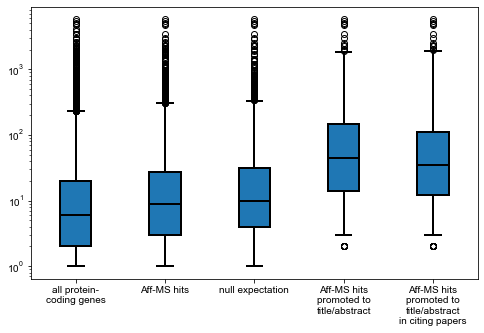

In [50]:
get_genes(biogrid_df)

In [44]:
orcs_results = biogrid.orcs('results')
orcs_studies = biogrid.orcs('studies')
orcs_studies = orcs_studies[orcs_studies['source_type'] == 'pubmed']

In [65]:
orcs_studies[orcs_studies['source_id'].astype(int).isin(gene2pubmed['pubmed_id']) & 
             (orcs_studies['taxon_ncbi'] == 9606)]#['source_id'].value_counts()

,orcs_screen_id,source_id,source_type,author,screen_name,scores_size,full_size,full_size_available,number_of_hits,analysis,...,score.1_type,score.2_type,score.3_type,score.4_type,score.5_type,taxon_ncbi,organism_official,notes,source,screen_rationale
44,141,27869803,pubmed,Steinhart Z (2017),1-PMID27869803,17226,17226,Yes,2174,BAGEL,...,Bayes Factor,-,-,-,-,9606,H. sapiens,Genes with a Bayes Factor (BF) above the thres...,BioGRID ORCS,Cell-essential genes
45,142,27869803,pubmed,Steinhart Z (2017),2-PMID27869803,17226,17226,Yes,2072,BAGEL,...,Bayes Factor,-,-,-,-,9606,H. sapiens,Genes with a Bayes Factor (BF) above the thres...,BioGRID ORCS,Cell-essential genes
46,143,27869803,pubmed,Steinhart Z (2017),3-PMID27869803,17226,17226,Yes,936,BAGEL,...,Bayes Factor,-,-,-,-,9606,H. sapiens,Genes with a Bayes Factor (BF) above the thres...,BioGRID ORCS,Cell-essential genes
69,178,28894007,pubmed,Gulbranson DR (2017),1-PMID28894007,18737,18737,Yes,329,MaGeCK,...,p-Value,FDR,-,-,-,9606,H. sapiens,Authors screened cells for exocytosis defects....,BioGRID ORCS,Exocytosis
293,405,28775154,pubmed,Stewart SE (2017),1-PMID28775154,20916,20916,Yes,1174,RSA,...,Log10 (p-value),-,-,-,-,9606,H. sapiens,Authors screened for genes required for cell ...,BioGRID ORCS,Regulators or GAL3 surface localization
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,1164,31801065,pubmed,Hyrina A (2019),2-PMID31801065,19049,19049,Yes,38,RSA,...,Log2,RSA,-,-,-,9606,H. sapiens,authors stained Hep-G2(HBV) cells with an HBsA...,BioGRID ORCS,Anti-HBsAg (hepatitis B virus surface antigen)...
959,1165,31801065,pubmed,Hyrina A (2019),3-PMID31801065,19049,19049,Yes,1,RSA,...,Log2,RSA,-,-,-,9606,H. sapiens,"KO of PARP10 potentiates activity of RG7834, a...",BioGRID ORCS,Decreased hepatitis B virus antigen surface ex...
960,1166,31801065,pubmed,Hyrina A (2019),4-PMID31801065,19049,19049,Yes,3,RSA,...,Log2,RSA,-,-,-,9606,H. sapiens,KO of hit genes suppresses the activity of RG7...,BioGRID ORCS,Increased hepatitis B virus antigen surface ex...
1005,1216,30860482,pubmed,Hong AL (2019),1-PMID30860482,135,444,No,135,RIGER,...,p-Value,NES (Normalized enrichment score),-,-,-,9606,H. sapiens,-,BioGRID ORCS,Cell-essential genes


In [71]:
(orcs_results[orcs_results['orcs_screen_id'].isin([1216, 1217])]['gene_ncbi'] == 11065).sum()

0